This note book appiels downsampling masks to the fully sampled data from the fastMRI set (based on test_notebook2.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from matplotlib.gridspec import GridSpec
import torch
import fastmri
import os
import pywt

In [2]:
# read the files on my local computer

os.chdir('/Users/korat/Desktop/BEP/Programmeren/fastmri/brain/train')


In [3]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 1EEB-8C6E

 Directory of C:\Users\korat\Desktop\BEP\Programmeren\fastmri\brain\train

13-04-2021  11:38    <DIR>          .
13-04-2021  11:38    <DIR>          ..
13-04-2021  09:27       530.858.000 file_brain_AXFLAIR_200_6002425.h5
13-04-2021  09:28       464.502.800 file_brain_AXFLAIR_200_6002428.h5
13-04-2021  09:29       530.858.008 file_brain_AXFLAIR_200_6002429.h5
13-04-2021  09:30       425.999.920 file_brain_AXFLAIR_200_6002435.h5
13-04-2021  09:31       425.999.920 file_brain_AXFLAIR_200_6002442.h5
               5 File(s)  2.378.218.648 bytes
               2 Dir(s)  30.634.520.576 bytes free


In [4]:
fname = 'file_brain_AXFLAIR_200_6002425.h5'
data = h5py.File(fname, 'r')
data.keys()

<KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>

In [5]:
# Cell reads data on the hinton server 

# fname = '/home/svangurp/scratch/fastMRI/brain/train/file_brain_AXFLAIR_200_6002425.h5'
# data = h5py.File(fname, 'r')
# data.keys()

In [6]:
kspace_complex = data['kspace'][()] # in this one i don't split the coplex values
kspace = data['kspace'][()]
recon_rss= data['reconstruction_rss'][()]
print('shape k-space:',kspace.shape, '. shape reconstructed data',recon_rss.shape)

shape k-space: (16, 20, 640, 320) . shape reconstructed data (16, 320, 320)


In [7]:


# This function converts np.arrays to pytorch tensors
def to_tensor(data: np.ndarray) -> torch.Tensor:
    """
    Convert numpy array to PyTorch tensor.

    For complex arrays, the real and imaginary parts are stacked along the last
    dimension.

    Args:
        data: Input numpy array.

    Returns:
        PyTorch version of data.
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)


#this function crops the data 
def complex_center_crop(data, shape):
    """
    Apply a center crop to the input image or batch of complex images.

    Args:
        data: The complex input tensor to be center cropped. It should have at
            least 3 dimensions and the cropping is applied along dimensions -3
            and -2 and the last dimensions should have a size of 2.
        shape: The output shape. The shape should be smaller than the
            corresponding dimensions of data.

    Returns:
        The center cropped image
    """
    if not (0 < shape[0] <= data.shape[-3] and 0 < shape[1] <= data.shape[-2]):
        raise ValueError("Invalid shapes.")

    w_from = (data.shape[-3] - shape[0]) // 2
    h_from = (data.shape[-2] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]

    return data[..., w_from:w_to, h_from:h_to, :]

In [8]:
with h5py.File(fname, "r") as hf:
    kspace_tensor = to_tensor(hf["kspace"][()])

    crop_size = (320, 320)

    # inverse Fourier Transform to get zero filled solution
    image = fastmri.ifft2c(kspace_tensor)

    # check for FLAIR 203
    if image.shape[-2] < crop_size[1]:
        crop_size = (image.shape[-2], image.shape[-2])
    print(image.shape)
    # crop input image
    image = complex_center_crop(image, crop_size)

    # absolute value
    image = fastmri.complex_abs(image)

    # apply Root-Sum-of-Squares if multicoil
    image = fastmri.rss(image, dim=1)
    

torch.Size([16, 20, 640, 320, 2])


In [9]:
print('shape k-space (real and im part seperated):',kspace_tensor.shape)
print('shape image',image.shape)


shape k-space (real and im part seperated): torch.Size([16, 20, 640, 320, 2])
shape image torch.Size([16, 320, 320])


In [10]:
with h5py.File(fname, "r") as hf:
    kspace = hf["kspace"][()]
    
kspace = np.stack((kspace.real, kspace.imag), axis=-1)

im_space = fastmri.ifft2c(torch.from_numpy(kspace)).detach().cpu().numpy()

cropped_imspace = complex_center_crop(im_space,(320,320))


# combine real and imag parts from last dim to transform it to complex data
complex_abs_cropped_imspace = np.sqrt(np.sum(cropped_imspace ** 2, -1))
print(complex_abs_cropped_imspace.shape)
# coil combination - rss
rss_imspace = np.sqrt(np.sum(complex_abs_cropped_imspace**2,1))

# rss_imspace = image.cpu().numpy()
_rss_imspace = np.concatenate([rss_imspace[sl] for sl in range(5)], -1)
_recon_rss = np.concatenate([recon_rss[sl] for sl in range(5)], -1)

(16, 20, 320, 320)


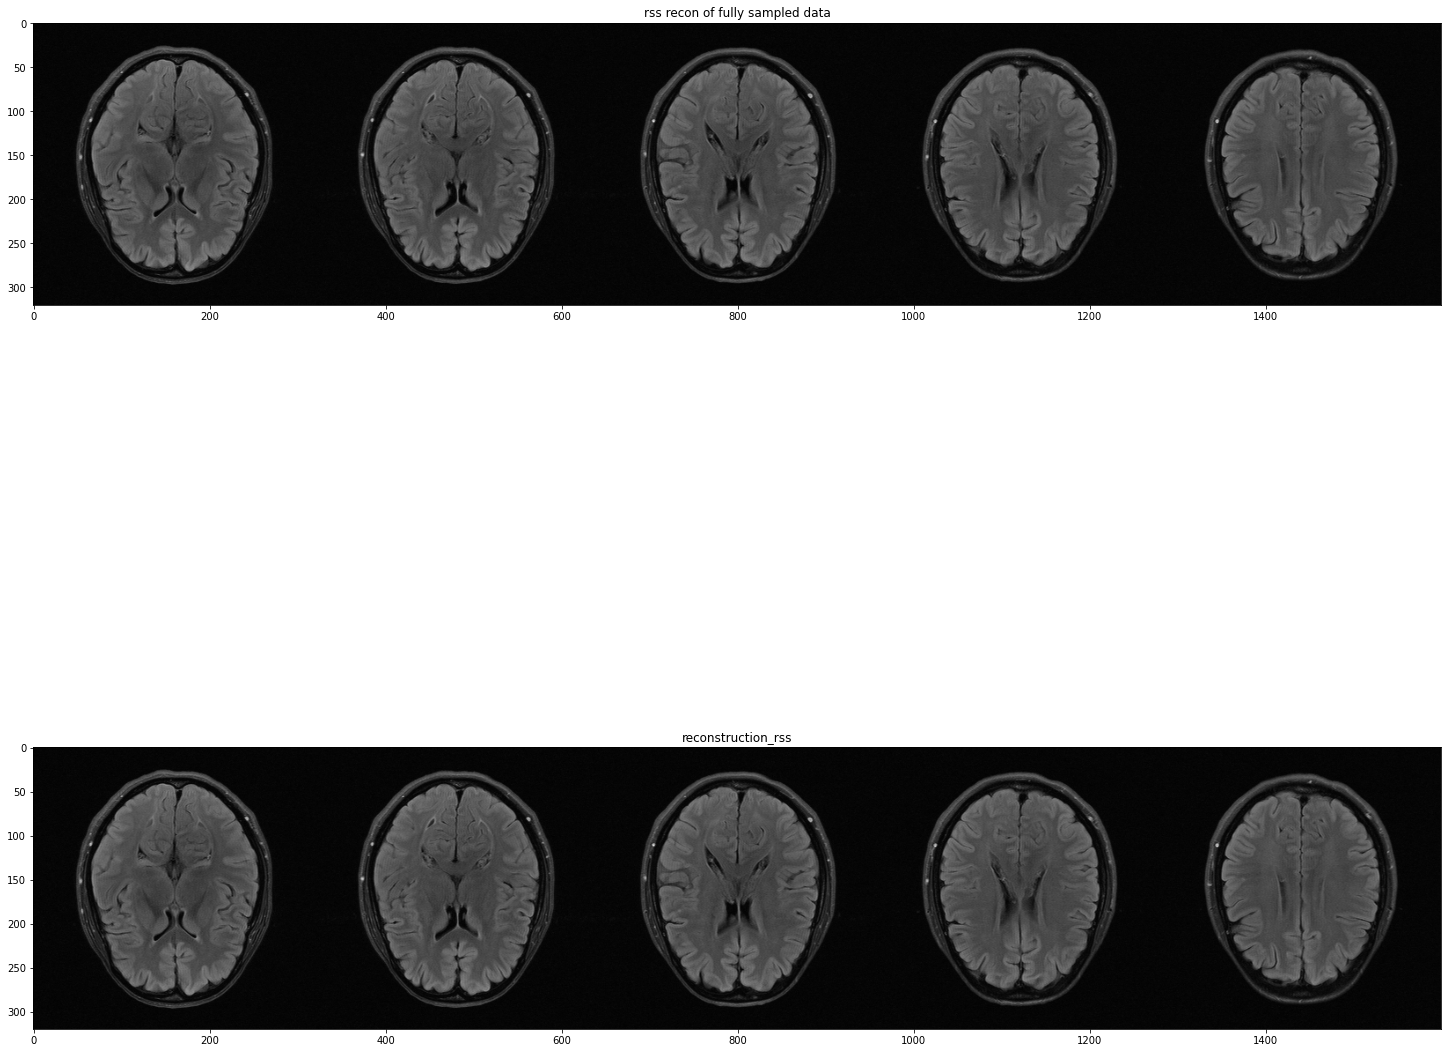

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(20,20))
gs = GridSpec(2, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(np.abs(_rss_imspace),cmap='gray')
ax1.set_title('rss recon of fully sampled data')

ax3 = fig.add_subplot(gs[1, 0])
ax3.imshow(np.abs(_recon_rss), cmap='gray')
ax3.set_title('reconstruction_rss')

plt.show()

In [12]:
# This function crates a mask with a fully sampled center and a random sample 

# the func assums that multi_coil_kspace has shape: (slices,coils,height, width)

def disk_mask_func(multi_coil_kspace, disk_radius):
    number_of_slices, number_of_coild,height, width = multi_coil_kspace.shape

    disk_mask = np.multiply(np.abs(np.random.randint(0,2,(height,width))),np.abs(np.random.randint(0,2,(height,width))))
    
    for i in range(height):
        for j in range(width):
            if np.sqrt(((i-(height/2))**2)+(j-(width/2))**2) <= disk_radius:
                disk_mask[i][j] = 1
                

    return disk_mask


#test of the function

# disk_mask = disk_mask_func(kspace_complex, disk_radius = 10)
# print('number of nonzero elements in the mask',np.count_nonzero(disk_mask))
# plt.imshow(disk_mask)
# plt.show()

In [13]:
# This function crates a parallel mask with horisontal lines
# the func assums that multi_coil_kspace has shape: (slices,coils,eight, width)

def parallel_mask_func(multi_coil_kspace, number_of_lines):
    number_of_slices, number_of_coild,height, width = multi_coil_kspace.shape
    
    step_size = int(height/number_of_lines)
    parallel_mask = np.zeros((height,width))

    
    for i in range(0,height,step_size):
        parallel_mask[i][:] = 1
    
    return parallel_mask
    
    
# test of the parallel_mask_func

# parallel_mask = parallel_mask_func(kspace_complex,number_of_lines = 100)
# plt.imshow(parallel_mask, cmap='gray')
# plt.show()    

In [14]:
# this function applies a mask to multicoil data, in this case the k-space and the mask have to be the same size
# the function does not combine the coils

# the func assums that multi_coil_kspace has shape: (slices,coils,eight, width)

def multicoil_masking_func(multi_coil_kspace, mask):
    
    number_of_slices, number_of_coils, height, width = multi_coil_kspace.shape
    masked_kspace_complex = np.zeros((multi_coil_kspace.shape), dtype = np.complex) 
    
    for slice in range(number_of_slices):
        for coil in range(number_of_coils):
            masked_kspace_complex[slice,coil,:,:] = np.multiply(multi_coil_kspace[slice,coil,:,:],mask)
    
    return masked_kspace_complex

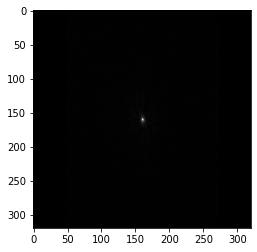

In [15]:
#this function crops a np array along the last two dim's 
# kspace has to be of the form: number_of_slices, number_of_coild,height, width = kspace.shape
def center_crop_nparray(kspace, new_height, new_width):
    number_of_slices, number_of_coild,height, width = kspace.shape


    croped = kspace[:,:,int(height/2-new_height/2):int(height/2+new_height/2),int(width/2-new_width/2):int(width/2+new_width/2)]
    
    return croped


# test 
croped = center_crop_nparray(kspace_complex, new_height = 320, new_width = 320)   
croped.shape
plt.imshow(np.abs(croped[0,0,:,:]), cmap ='gray')
plt.show()

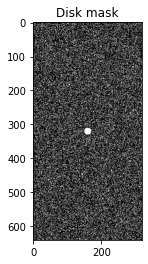

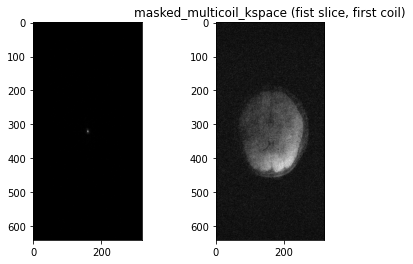

45875200
11519360


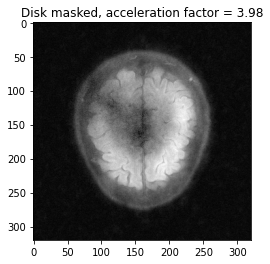

In [16]:
# Creating a disk_mask 
disk_mask = disk_mask_func(kspace_complex, disk_radius = 10)
#plotting
plt.imshow((disk_mask), cmap ='gray')
plt.title('Disk mask')
plt.show()


# applying the mask to the multi coil data
masked_multicoil_kspace = multicoil_masking_func(kspace_complex,disk_mask)
#plotting
plt.subplot(1,2,1)
plt.imshow((np.abs(masked_multicoil_kspace[0,0,:,:])), cmap ='gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(np.fft.fftshift(np.fft.ifft2(masked_multicoil_kspace[0,0,:,:]))), cmap ='gray')
plt.title('masked_multicoil_kspace (fist slice, first coil)')
plt.show()

# go to image space
masked_multicoil_image = np.fft.fftshift(np.fft.ifft2(masked_multicoil_kspace))

# center crop
masked_multicoil_cropped_image = center_crop_nparray(masked_multicoil_image, new_height = 320, new_width = 320)

# calculate the acceleration factor
original_nonzero = np.count_nonzero(kspace_complex)
print(original_nonzero)
masked_nonzero = np.count_nonzero(masked_multicoil_kspace)
print(masked_nonzero)
acceleration_factor = original_nonzero/masked_nonzero

# coil combination rss
masked_rss_croped_image = np.sqrt(np.sum(masked_multicoil_cropped_image**2,1))
#plotting
plt.imshow(abs(masked_rss_croped_image[0,:,:]),cmap = 'gray')
plt.title(f'Disk masked, acceleration factor = {round(acceleration_factor,2)}' )
plt.show()



In [18]:
# Here I will try to implement CS recon
img = abs(masked_multicoil_image[0,:,:])

# coil combination rss in kspace
kspace = masked_multicoil_kspace
masked_rss_kspace = np.sqrt(np.sum(kspace**2,1))
print(masked_rss_kspace.shape)
n = 2

# Wavelet decoposition 
coeffs = pywt.wavedec2(img, wavelet = 'db1', level = n)


arr, coeff_slices = pywt.coeffs_to_array(coeffs,1)

plt.imshow(arr,  cmap = 'gray')
plt.show()

coeffs2 = pywt.waverec2(coeffs, wavelet = 'db1')
arr2, coeff_slices2 = pywt.coeffs_to_array(coeffs)

plt.imshow(coeffs2)
plt.show()

(16, 640, 320)


ValueError: coeffs corresponds to a DWT performed over only a subset of the axes.  In this case, axes must be specified.

In [ ]:
# Creating a parallel_mask 
parallel_mask = parallel_mask_func(kspace_complex, number_of_lines = 150)
#plotting
plt.imshow((parallel_mask), cmap ='gray')
plt.title('Parallel mask')
plt.show()


# applying the mask to the multi coil data
masked_multicoil_kspace = multicoil_masking_func(kspace_complex,parallel_mask)
#plotting
plt.subplot(1,2,1)
plt.imshow((np.abs(masked_multicoil_kspace[0,0,:,:])), cmap ='gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(np.fft.fftshift(np.fft.ifft2(masked_multicoil_kspace[0,0,:,:]))), cmap ='gray')
plt.title('masked_multicoil_kspace (fist slice, first coil)')
plt.show()

# go to image space
masked_multicoil_image = np.fft.fftshift(np.fft.ifft2(masked_multicoil_kspace))

# center crop
masked_multicoil_cropped_image = center_crop_nparray(masked_multicoil_image, new_height = 320, new_width = 320)

# calculate the acceleration factor
original_nonzero = np.count_nonzero(kspace_complex)
masked_nonzero = np.count_nonzero(masked_multicoil_kspace)

acceleration_factor = original_nonzero/masked_nonzero

# coil combination rss
masked_rss_croped_image = np.sqrt(np.sum(masked_multicoil_cropped_image**2,1))
#plotting
plt.imshow(abs(masked_rss_croped_image[0,:,:]),cmap = 'gray')
plt.title(f'Paralell masked, acceleration factor = {round(acceleration_factor,2)}' )
plt.show()

In [ ]:



# masked_multicoil_kspace

# number_of_slices, number_of_coild,height, width = masked_multicoil_kspace.shape
# print(np.abs(masked_multicoil_kspace[0,0,0,:]))
# multislice_kspace[0,0,:,:].shape
# anti_aliased_kspace = np.zeros((heigth,width))

# count = 0
# for n in range(height):
    
    
#     if np.sum(np.abs(multislice_kspace[0,0,n,:])) == 0: #and n-1 >= 0 and n+1 <= heigth-1:
        
# #         for m in range(width):
            
#             #anti_aliased_kspace[n,m] = (multislice_kspace[0,0,n+1,m] + multislice_kspace[0,0,n-1,m])/2
            
            
# print(count)
# anti_aliased  = np.fft.fftshift(np.fft.ifft2(anti_aliased_kspace))
# aliased = np.fft.fftshift(np.fft.ifft2(multislice_kspace[0,0,:,:]))
# print(anti_aliased.shape)
# plt.imshow(np.abs(anti_aliased))
# plt.show()

# plt.imshow(np.abs(aliased))
# plt.show()

In [ ]:
# function creates a Gausian mask
# the func assums that multicoil_ksapce has shape: (slices,coils,eight, width)
# sigma is the standard diviation of the gaussian 

# def gauss_mask_func(multicoil_ksapce, sigma, acceleration):
    
#     number_of_slices, number_of_coils, height, width = multicoil_ksapce.shape
    
#     gauss_mask = np.ones((height,width))
#     current_acceleration = 1
#     number_elements = height*width # total number of elements in the mask
#     count_zero = 0 # this variable counts the number of non-zero elemnets in the mask
#     fout_count  = 0
    
#     while current_acceleration <= acceleration:
        
#         x = int(np.random.normal(loc= round(width/2), scale= sigma, size=None))
#         y = int(np.random.normal(loc= round(height/2), scale= sigma, size=None))
    
#         if x > 0 and x < width and y > 0 and y < height:
            
#             if gauss_mask[y,x] == 1:
#                 gauss_mask[y,x] = 0
#                 count_zero += 1
#             else:
#                 fout_count +=1
#                 print(fout_count)

#         current_acceleration = number_elements/(number_elements-count_zero)
#         print(current_acceleration)
#     return gauss_mask
    
    
    
# gauss_mask = gauss_mask_func(kspace_complex, sigma = 0.1, acceleration = 4)     


# plt.imshow(gauss_mask)
# plt.show()